In [1]:
from tqdm.auto import tqdm
import torch 
import transformers
from transformers import PreTrainedTokenizer
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel, RobertaForTokenClassification
#from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses, util
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
#import matplotlib.pyplot as plt 
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel, PreTrainedTokenizerFast, RobertaTokenizerFast
#from torch.nn import CosineEmbeddingLoss
import random
#from torch.nn import CosineEmbeddingLoss
from torch import nn
#Build up to SBERT model 

[2024-02-15 17:42:27,729] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import DataLoader,random_split,SubsetRandomSampler

In [3]:
#df = pd.read_csv("/shared/3/projects/benlitterer/podcastData/hostIdentification/itunesGTsubset.tsv", sep="\t") 

In [4]:
#set seeds
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [5]:
trainDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/hostIdentification/trainTestVal2_5/descTrainLabelled.csv")
trainDf = trainDf.dropna(subset=["tag"])
trainDf["groundTruth"] = trainDf["tag"] == "HOST"
trainDf["groundTruth"] = trainDf["groundTruth"].astype(int)
trainDf["entSnippets"] = trainDf["left"] + trainDf["ent"] + trainDf["right"] 

valDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/hostIdentification/trainTestVal2_5/descValLabelled.csv")
valDf = valDf.dropna(subset=["tag"])
valDf["groundTruth"] = valDf["tag"] == "HOST"
valDf["groundTruth"] = valDf["groundTruth"].astype(int)
valDf["entSnippets"] = valDf["left"] + valDf["ent"] + valDf["right"] 

trainDf = pd.concat([trainDf, valDf], axis=0) 



In [275]:
#hmmm why do we also have the same author ids? 
trainDf["itunesAuthor"].value_counts()

itunesAuthor
Entertainment Radio    10
The Athletic            8
Claibs Online           7
Blue Wire               5
Jack Goodwin            5
                       ..
Carmen Brown            1
Vertical Church         1
Ashley Little           1
Aurelia Grierson        1
Johnny Ciao             1
Name: count, Length: 649, dtype: int64

In [278]:
#we do have some repeated entities
pd.DataFrame(trainDf["ent"].value_counts()).head(10)

,count
ent,
George Floyd,14
Jesus Christ,7
Ryan Reynolds,4
Quincy AmeriQua,4
Joe Biden,4
Joe Rogan,3
John chapter,3
Donald Trump,3
Michael Jordan,3


In [ ]:
trainDf = trainDf[["left", "right", "ent", "tag", 'first500', '500ent',
       '500start', '500end', '500type', 'itunesAuthor', 'levenshtein',
       'groundTruth', 'entSnippets']]

trainDf = trainDf.dropna()

In [268]:
trainDf.head()

,left,right,ent,tag,first500,500ent,500start,500end,500type,itunesAuthor,levenshtein,groundTruth,entSnippets
0,content You're listening to Reflections on Lea...,and welcome to the Strengthen Your Leadership ...,Carl Bimchaw,HOST,content You're listening to Reflections on Lea...,Carl Bimchaw,182,194,PERSON,Karl Bimshas,75,1,content You're listening to Reflections on Lea...
1,content Harry Potter. Harry Potter. Harry Pott...,. Harry Potter. Harry Potter. Harry Potter. Ha...,Harry Potter,OTHER,content Harry Potter. Harry Potter. Harry Pott...,Harry Potter,134,146,PERSON,Harry Potter,100,0,content Harry Potter. Harry Potter. Harry Pott...
2,time I got to listen to Coach Bowling will spe...,"was a coach at San Jose State"" had some reall...",Bill Berry,OTHER,content Welcome Inside Real Talk Basketball wi...,Bill Berry,323,333,PERSON,Rex Walters,29,0,time I got to listen to Coach Bowling will spe...
3,all the way when he was in the third grade. In...,from NC State and the most recent one being r...,Patrick Bailey,OTHER,"content What's up guys"" welcome back to anothe...",Patrick Bailey,694,708,PERSON,Cullen Craig,23,0,all the way when he was in the third grade. In...
4,Falbani. I'm Taka Falbani. I'm Taka Falbani. I...,. I'm Taka Falbani. I'm Taka Falbani. I'm Taka...,Taka Falbani,HOST,"content Hi"" hi guys"" I'm Taka Falbani. I'm her...",Taka Falbani,2477,2489,PERSON,Agus Sri,30,1,Falbani. I'm Taka Falbani. I'm Taka Falbani. I...


In [228]:
#create snippet from 
trainDf["snippetStart"] = trainDf.apply(lambda x: x["entSnippets"].lower().find(x["ent"].lower()), axis=1)


In [229]:

trainDf = trainDf[trainDf["snippetStart"] != -1]
#valDf = valDf[valDf["snippetStart"] != -1]

trainDf["snippetEnd"] = trainDf["snippetStart"] + trainDf["500end"] - trainDf["500start"]
#valDf["snippetEnd"] = valDf["snippetStart"] + valDf["500end"] - valDf["500start"]

def extractEnt(inRow): 
    return inRow["entSnippets"][inRow["snippetStart"]:inRow["snippetEnd"]]

#just for sanity checking whether our inferred start/end indices are correct 
#looks good!
trainDf["extractedEnt"] = trainDf.apply(extractEnt, axis=1)
#valDf["extractedEnt"] = valDf.apply(extractEnt, axis=1)

In [230]:
deviceNum = 1
device = torch.device("cuda:" + str(deviceNum) if torch.cuda.is_available() else "cpu")

In [231]:

#put ground truth values into a list 
trainDf = trainDf[["entSnippets", "groundTruth", "snippetStart", "snippetEnd"]] 
trainDf = trainDf.reset_index(drop=True)

#valDf = valDf[["entSnippets", "groundTruth", "snippetStart", "snippetEnd"]] 
#valDf = valDf.reset_index(drop=True)

#get train, valid, test 
#trainDf, testDf = train_test_split(leanDf, test_size=0.3) 
#validDf, testDf = train_test_split(testDf, test_size=0.666) 


#validDataset = Dataset.from_pandas(valDf)
#testDataset = Datase|t.from_pandas(testDf)

In [232]:
# Preprocessing
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length=512, padding="max_length", truncation=True)

In [233]:
tokenized = []
for snip in trainDf["entSnippets"]: 
    tokenized.append(tokenizer(snip, padding = "max_length", truncation=True, return_offsets_mapping=True))

In [234]:
trainDf = pd.concat([trainDf, pd.DataFrame.from_records(tokenized)], axis=1) 

In [235]:
#find the token indices which correspond to our entity 
def getTokenIndices(start, end, offsets):
    """
    print(start) 
    print(end) 
    print(offsets[:20]) 
    """

    currIndices = []
    for j, offset in enumerate(offsets): 
        offsetL, offsetR = offset
        if offsetL >= start and offsetR <= end: 
            currIndices.append(j)

    return currIndices

In [236]:
#posTokens is useful with a BIO setup 
trainDf["posTokens"] = trainDf.apply(lambda row: getTokenIndices(row["snippetStart"], row["snippetEnd"], row["offset_mapping"]), axis=1)

labList = []
for i, row in trainDf.iterrows(): 
    tokCount = sum(row["attention_mask"])
    paddingLen = len(row["attention_mask"]) - tokCount
    
    labels = ([0] * tokCount) + ([2] * paddingLen)
    
    for posIndex in row["posTokens"]: 
        labels[posIndex] = 1
    
    labList.append(labels) 

trainDf["labels"] = labList

trainDf["entsTokenized"] = trainDf.apply(lambda row: [tokenizer.decode(row["input_ids"][i]) for i in row["posTokens"]], axis=1) 

In [240]:
trainDf.sample(10)

,entSnippets,groundTruth,snippetStart,snippetEnd,attention_mask,input_ids,offset_mapping,posTokens,labels,entsTokenized
575,greatest terrorist threat in America is white ...,0,171,185,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 12338, 990, 4888, 1856, 11, 730, 16, 1104,...","[(0, 0), (0, 5), (5, 8), (9, 18), (19, 25), (2...","[34, 35]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Bernie, Sanders]"
693,will show it to the screen that we are on a zo...,0,136,152,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 6677, 311, 24, 7, 5, 2441, 14, 52, 32, 15,...","[(0, 0), (0, 4), (5, 9), (10, 12), (13, 15), (...","[33, 34, 35, 36, 37]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ Gabriel, le, J, az, ous]"
79,distinctly unmonkey square. -Maybe they didn't...,0,193,208,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 17165, 24115, 352, 542, 45384, 3925, 4, 11...","[(0, 0), (0, 4), (4, 8), (8, 10), (11, 13), (1...","[50, 51, 52, 53, 54, 55, 56]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ Bre, x, se, f, Ak, al, ten]"
577,"your cart today at Kroger.com. Kroger"" fresh f...",1,186,198,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 16625, 9727, 452, 23, 14226, 2403, 4, 175,...","[(0, 0), (0, 4), (5, 9), (10, 15), (16, 18), (...","[49, 50]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ Andrea, Lopez]"
667,"content [MUSIC] From Relay FM"" this is the Pen...",1,142,153,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 10166, 646, 448, 3048, 2371, 742, 1740, 81...","[(0, 0), (0, 7), (8, 9), (9, 10), (10, 12), (1...","[41, 42, 43]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ Mike, Hur, ley]"
428,40 years later. But he went to make his dream ...,0,137,150,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1749, 107, 423, 4, 125, 37, 439, 7, 146, 3...","[(0, 0), (0, 2), (3, 8), (9, 14), (14, 15), (1...","[33, 34, 35, 36, 37]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ Mir, iam, McK, eb, a]"
345,content Welcome to the Sony Alpha Photographer...,0,102,111,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 10166, 14826, 7, 5, 6366, 7829, 23769, 307...","[(0, 0), (0, 7), (8, 15), (16, 18), (19, 22), ...","[21, 22]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Gary, Hart]"
603,"Hamlin"" Denny Hamlin tenths. Now we take a loo...",0,169,183,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 30907, 2614, 113, 211, 11867, 3600, 2614, ...","[(0, 0), (0, 3), (3, 6), (6, 7), (8, 9), (9, 1...","[46, 47, 48, 49, 50]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ Brad, K, isl, av, ski]"
652,all things NFL. The sun is shining across the ...,0,148,161,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1250, 383, 1485, 4, 20, 3778, 16, 21003, 4...","[(0, 0), (0, 3), (4, 10), (11, 14), (14, 15), ...","[36, 37, 38]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ Jeff, Ryan, bold]"
715,"Lee Tignor"" Michael Espinel"" Michael Noel"" Kev...",0,218,235,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 24403, 255, 4932, 368, 113, 988, 11631, 16...","[(0, 0), (0, 3), (4, 5), (5, 8), (8, 10), (10,...","[60, 61]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ Christopher, Davis]"


In [241]:
#get an "index" column that just indexes the row of the dataframe we have 
trainDf = trainDf.reset_index(drop=True).reset_index()
tokenIxList = list(trainDf["posTokens"])

dataset = Dataset.from_pandas(trainDf)
dataset.set_format(type='torch', columns=["index", "entSnippets", "groundTruth", "input_ids", "attention_mask"])
#validDataset.set_format(type='torch', columns=["entSnippets", "groundTruth", "input_ids", "snippetStart", "snippetEnd", "attention_mask", "offset_mapping"])

In [245]:
class Model(nn.Module):
    def __init__(self, ixList):
        #def __init__(self):
        super(Model,self).__init__()
        self.model = RobertaModel.from_pretrained('roberta-base')
        self.l1 = nn.Linear(768, 1)
        self.sig = nn.Sigmoid()
        self.ixList = ixList
        
    def mean_pooling(self, token_embeddings, attention_mask): 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    def forward(self, input_ids, attention_mask, index): 
        
        #encode sentence and get mean pooled sentence representation 
        output = self.model(input_ids, attention_mask=attention_mask)
        
        outIndices = [self.ixList[ix] for ix in index]
        embeddingMeans = []
        batchIter = 0
        for batchIter in range(input_ids.shape[0]): 
            
            #get the last layer of the model 
            hiddenStates = output[0]
            
            #get the embeddings corresponding to the entity we're interested in 
            tokStates = [hiddenStates[batchIter][tokIndex,:] for tokIndex in outIndices[batchIter]]
            
            #take the mean over all embeddings for an entity 
            embeddingMean = torch.stack(tokStates).mean(dim=0)
            
            #append this so we get the mean embedding for each 
            #training example in this batch 
            embeddingMeans.append(embeddingMean) 
            #embeddingMeans.append(hiddenStates[batchIter][outIndices[batchIter][0],:])
            
        embeddingMeans = torch.stack(embeddingMeans)
        """
        working code just used this!
        embeddingMeans = self.mean_pooling(output[0], attention_mask)
        """
        probs = self.sig(self.l1(embeddingMeans)).squeeze()
        
        
        return probs

In [246]:
"""
as a sanity check, this prints the Named Entitiy of the first
element in the batch that was most recently processed 
tempModel = RobertaModel.from_pretrained('roberta-base')
output = tempModel(batch["input_ids"], attention_mask=batch["attention_mask"])
currIndex = batch["index"][0]
tokIndices = tokenIxList[currIndex]
tokenizer.decode(batch["input_ids"][0][tokIndices])
#trainDf.loc[443]
"""

'\nas a sanity check, this prints the Named Entitiy of the first\nelement in the batch that was most recently processed \ntempModel = RobertaModel.from_pretrained(\'roberta-base\')\noutput = tempModel(batch["input_ids"], attention_mask=batch["attention_mask"])\ncurrIndex = batch["index"][0]\ntokIndices = tokenIxList[currIndex]\ntokenizer.decode(batch["input_ids"][0][tokIndices])\n#trainDf.loc[443]\n'

In [252]:

#validation function 
def validate(model, validLoader, loss_func):
    model.eval()
    
    validPreds = []
    validGts = []
    validLoss = []
    outList = [[], []]
    for batch in tqdm(validLoader): 
        
        optim.zero_grad()
        
        input_ids = batch["input_ids"].to(device) 
        attention_mask = batch["attention_mask"].to(device) 
        index = batch["index"]
        
        gt = batch["groundTruth"].to(device).to(torch.float32)
        probs = model(input_ids, attention_mask, index) #.to(torch.float32)
        

        loss = loss_func(probs, gt) 
        preds = (probs > .5).to(int).cpu().tolist()
        gt = gt.to(int).detach().cpu().tolist()

        #update the lists of predictions, ground truths for train metrics
        validPreds += preds
        validGts += gt
        validLoss.append(loss.cpu().detach().item())

        
    
    f1 = f1_score(validPreds, validGts)
    validLossMean = np.mean(validLoss)
    
    model.train()
    return [validPreds, validGts, f1, validLossMean]
    
    
   


In [254]:
def train(model, fold, epochs, optim, scheduler, loss_func, trainLoader, validLoader): 
    
    #how often should we be getting our train metrics 
    METRIC_FREQ = 3
    trainLen = len(trainLoader) 
    metricSteps = int(len(trainLoader) / METRIC_FREQ) 
    validIndices = list(np.arange(0, len(trainLoader), metricSteps))

    if trainLen not in validIndices: 
        validIndices += [trainLen]
    
    #lists to put our f1 scores in 
    lossList = []
    trainMetrics = []
    validMetrics = []
    
    finalPreds = []
    
    for epoch in range(epochs):
        print("EPOCH: " + str(epoch))

        model.train()  # make sure model is in training mode

        #DEBUGGING
        i = 0 
        currLossList = []
        currPreds = []
        currGts = []
        
        for batch in tqdm(trainLoader):
            optim.zero_grad()

            input_ids = batch["input_ids"].to(device) 
            attention_mask = batch["attention_mask"].to(device) 
            index = batch["index"]
            gt = batch["groundTruth"].to(device).to(torch.float32)

            probs = model(input_ids, attention_mask, index) #.to(torch.float32)

            #print(batch["index"]) 

            loss = loss_func(probs, gt) 
            loss.backward()
            optim.step()
            scheduler.step()

            #preds = preds.detach().cpu().tolist()
            #gt = gt.detach().cpu().tolist() 

            preds = (probs > .5).to(int).cpu().tolist()
            #preds = preds.detach().cpu().tolist()
            gt = gt.to(int).detach().cpu().tolist()

            #update the lists of predictions, ground truths for train metrics
            currPreds += preds
            currGts += gt
            currLossList.append(loss.cpu().detach().item())

            #if we've hit the number of steps where we want to 
            #get training metrics 
            if i in validIndices: 
                trainF1 = f1_score(currPreds, currGts)
                avgLoss = np.mean(currLossList)
                
                if i != 0: 
                    trainMetrics.append([fold, i, i/len(trainLoader), epoch, trainF1, avgLoss]) 
                
                 
                validPreds, validGts, validF1, validLossMean = validate(model, validLoader, loss_func)
                validMetrics.append([fold, i, i/len(trainLoader), epoch, validF1, validLossMean]) 
                                    
                """
                print(f"average loss: {np.mean(currLossList)}")
                print(f"F1: {f1_score(currPreds, currGts)}")
                print(currPreds[:20]) 
                print(currGts[:20]) 
                """
                
                #if this is our last run 
                #if i == validIndices[-1] and epoch == (epochs-1): 
                #    finalPreds.append([validPreds, validGts]) 
                
                currPreds = []
                currGts = []
                print(f"train f1: {trainF1}")
                print(f"valid f1: {validF1}") 
                print(f"learning rate {scheduler.get_last_lr()}")
                #print(model.l1.weight[0][:20]) 
                
            i += 1
    
    return [validPreds, validGts, trainMetrics, validMetrics]
                                    
    """       
    print(f"average loss: {np.mean(currLossList)}")
    print(f"F1: {f1_score(currPreds, currGts)}")
    print(f"learning rate {scheduler.get_last_lr()}")  
    """

In [255]:
BATCH_SIZE=4
EPOCHS=3

FOLDS=5
splits=KFold(n_splits=FOLDS,shuffle=True,random_state=42)
allMetrics = []

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    #initialize model 
    model = Model(tokenIxList).to(device)
    
    print('Fold {}'.format(fold + 1))

    trainSampler = SubsetRandomSampler(train_idx)
    validSampler = SubsetRandomSampler(val_idx)
    trainLoader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=trainSampler)
    validLoader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=validSampler)
    
    
    optim = torch.optim.Adam(model.parameters(), lr=2e-5)
    
    total_steps = int(len(trainLoader))*EPOCHS
    warmup_steps = int(0.1 * total_steps)
    
    scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup_steps, num_training_steps=total_steps - warmup_steps)
    loss_func = torch.nn.BCELoss()

    allMetrics.append(train(model, fold, EPOCHS, optim, scheduler, loss_func, trainLoader, validLoader))


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 1
EPOCH: 0


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.6666666666666666
valid f1: 0.47619047619047616
learning rate [4.1666666666666667e-07]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.32558139534883723
valid f1: 0.6753246753246753
learning rate [1.96875e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.7899159663865546
valid f1: 0.853932584269663
learning rate [1.6927083333333333e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.8307692307692308
valid f1: 0.8000000000000002
learning rate [1.416666666666667e-05]
EPOCH: 1


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 1.0
valid f1: 0.8000000000000002
learning rate [1.4114583333333334e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9172932330827067
valid f1: 0.8659793814432989
learning rate [1.1354166666666669e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.8985507246376812
valid f1: 0.8440366972477064
learning rate [8.59375e-06]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9312977099236641
valid f1: 0.8659793814432989
learning rate [5.833333333333334e-06]
EPOCH: 2


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 1.0
valid f1: 0.8659793814432989
learning rate [5.781250000000001e-06]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9594594594594594
valid f1: 0.8599999999999999
learning rate [3.0208333333333334e-06]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.991869918699187
valid f1: 0.8599999999999999
learning rate [2.604166666666667e-07]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9770992366412214
valid f1: 0.8599999999999999
learning rate [0.0]


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 2
EPOCH: 0


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.0
valid f1: 0.34848484848484856
learning rate [4.1666666666666667e-07]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.28865979381443296
valid f1: 0.8363636363636363
learning rate [1.96875e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.7727272727272727
valid f1: 0.8505747126436781
learning rate [1.6927083333333333e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.8661417322834646
valid f1: 0.9361702127659575
learning rate [1.416666666666667e-05]
EPOCH: 1


  0%|          | 0/160 [00:00<?, ?it/s]

/opt/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.0
valid f1: 0.9361702127659575
learning rate [1.4114583333333334e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9291338582677166
valid f1: 0.9130434782608696
learning rate [1.1354166666666669e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9090909090909092
valid f1: 0.9148936170212766
learning rate [8.59375e-06]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.923076923076923
valid f1: 0.9278350515463918
learning rate [5.833333333333334e-06]
EPOCH: 2


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 1.0
valid f1: 0.9278350515463918
learning rate [5.781250000000001e-06]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9696969696969696
valid f1: 0.9148936170212766
learning rate [3.0208333333333334e-06]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.96875
valid f1: 0.9148936170212766
learning rate [2.604166666666667e-07]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9577464788732394
valid f1: 0.9148936170212766
learning rate [0.0]


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 3
EPOCH: 0


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.4
valid f1: 0.43349753694581283
learning rate [4.1666666666666667e-07]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.3829787234042554
valid f1: 0.7368421052631579
learning rate [1.96875e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.8253968253968255
valid f1: 0.7865168539325843
learning rate [1.6927083333333333e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.8500000000000001
valid f1: 0.8275862068965518
learning rate [1.416666666666667e-05]
EPOCH: 1


  0%|          | 0/160 [00:00<?, ?it/s]

/opt/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.0
valid f1: 0.8139534883720929
learning rate [1.4114583333333334e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9142857142857143
valid f1: 0.8297872340425532
learning rate [1.1354166666666669e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9206349206349206
valid f1: 0.823529411764706
learning rate [8.59375e-06]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9444444444444444
valid f1: 0.8541666666666667
learning rate [5.833333333333334e-06]
EPOCH: 2


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 1.0
valid f1: 0.8541666666666667
learning rate [5.781250000000001e-06]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9594594594594594
valid f1: 0.8453608247422681
learning rate [3.0208333333333334e-06]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9806451612903225
valid f1: 0.8453608247422681
learning rate [2.604166666666667e-07]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9734513274336283
valid f1: 0.8453608247422681
learning rate [0.0]


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 4
EPOCH: 0


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.4
valid f1: 0.5345622119815668
learning rate [4.1666666666666667e-07]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.23703703703703705
valid f1: 0.8703703703703703
learning rate [1.96875e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.831858407079646
valid f1: 0.9009009009009009
learning rate [1.6927083333333333e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.7863247863247863
valid f1: 0.8285714285714285
learning rate [1.416666666666667e-05]
EPOCH: 1


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 1.0
valid f1: 0.8285714285714285
learning rate [1.4114583333333334e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.8849557522123894
valid f1: 0.9193548387096775
learning rate [1.1354166666666669e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9066666666666666
valid f1: 0.9047619047619048
learning rate [8.59375e-06]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9344262295081968
valid f1: 0.9298245614035087
learning rate [5.833333333333334e-06]
EPOCH: 2


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 1.0
valid f1: 0.9298245614035087
learning rate [5.781250000000001e-06]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9586776859504132
valid f1: 0.9180327868852458
learning rate [3.0208333333333334e-06]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9733333333333333
valid f1: 0.9333333333333333
learning rate [2.604166666666667e-07]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9411764705882353
valid f1: 0.9333333333333333
learning rate [0.0]


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 5
EPOCH: 0


  0%|          | 0/160 [00:00<?, ?it/s]

/opt/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.0
valid f1: 0.24
learning rate [4.1666666666666667e-07]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.08823529411764706
valid f1: 0.7288135593220337
learning rate [1.96875e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.6349206349206349
valid f1: 0.8155339805825242
learning rate [1.6927083333333333e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.8368794326241135
valid f1: 0.8686868686868686
learning rate [1.416666666666667e-05]
EPOCH: 1


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.8
valid f1: 0.8514851485148514
learning rate [1.4114583333333334e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9090909090909091
valid f1: 0.8653846153846154
learning rate [1.1354166666666669e-05]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.8867924528301886
valid f1: 0.8737864077669903
learning rate [8.59375e-06]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9147286821705427
valid f1: 0.8799999999999999
learning rate [5.833333333333334e-06]
EPOCH: 2


  0%|          | 0/160 [00:00<?, ?it/s]

/opt/anaconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.0
valid f1: 0.8979591836734695
learning rate [5.781250000000001e-06]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9635036496350364
valid f1: 0.8448275862068965
learning rate [3.0208333333333334e-06]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9850746268656716
valid f1: 0.8727272727272727
learning rate [2.604166666666667e-07]


  0%|          | 0/40 [00:00<?, ?it/s]

train f1: 0.9770992366412213
valid f1: 0.8727272727272727
learning rate [0.0]


In [256]:
#append all of the train matrices together 
trainOutput = []
validOutput = []
for i in range(len(allMetrics)): 
    trainOutput += allMetrics[i][2]
    validOutput += allMetrics[i][3]
    
trainDf = pd.DataFrame(trainOutput, columns=["fold", "step", "epochFrac", "epoch", "f1", "learningRate"]) 
trainDf["data"] =  "train"

validDf = pd.DataFrame(validOutput, columns=["fold", "step", "epochFrac", "epoch", "f1", "learningRate"]) 
validDf["data"] =  "valid"                     

#validDf["totalSteps"] = 
validDf["overallEpochFrac"] = validDf["epoch"] + validDf["epochFrac"]
trainDf["overallEpochFrac"] = trainDf["epoch"] + trainDf["epochFrac"]
metricDf = pd.concat([validDf, trainDf], axis=0) 

In [257]:
metricDf

,fold,step,epochFrac,epoch,f1,learningRate,data,overallEpochFrac
0,0,0,0.00000,0,0.476190,0.756611,valid,0.00000
1,0,53,0.33125,0,0.675325,0.425444,valid,0.33125
2,0,106,0.66250,0,0.853933,0.310617,valid,0.66250
3,0,159,0.99375,0,0.800000,0.293546,valid,0.99375
4,0,0,0.00000,1,0.800000,0.292710,valid,1.00000
...,...,...,...,...,...,...,...,...
40,4,106,0.66250,1,0.886792,0.177436,train,1.66250
41,4,159,0.99375,1,0.914729,0.170969,train,1.99375
42,4,53,0.33125,2,0.963504,0.056884,train,2.33125
43,4,106,0.66250,2,0.985075,0.053792,train,2.66250


Text(0, 0.5, 'F1 score')

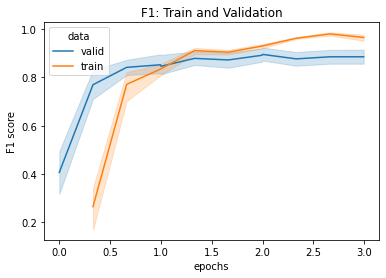

In [258]:
sns.lineplot(data=metricDf, x="overallEpochFrac", y="f1", hue="data")
plt.title("F1: Train and Validation") 
plt.xlabel("epochs") 
plt.ylabel("F1 score") 

In [259]:
validPreds = []
validGts = []
for i in range(len(allMetrics)): 
    validPreds += allMetrics[i][0]
    validGts += allMetrics[i][1]
    

In [260]:
f1_score(validPreds, validGts) 

0.8867562380038388

In [262]:
#rows: what the ground truth is (0 versus 1) 
#columns: what we predicted (0 versus 1) 

confusion_matrix(validGts, validPreds)

array([[508,  36],
       [ 23, 231]])

In [197]:
#print(f"{validPreds[:30]}") 
#print(f"{validGts[:30]}") 

[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]
[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]


In [173]:
for i in range(len(allMetrics)):
    print(allMetrics[i])

In [102]:
len(dataset)

798

In [263]:
WEIGHTS_PATH="/shared/3/projects/benlitterer/podcastData/hostIdentification/robertaTokenClassifier/weights/feb15.weights"
torch.save(model.state_dict(), WEIGHTS_PATH)
